# Code from ER class

In [57]:
import scipy as sp
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

def rand_canonical_f(Nnode, Plink):
    A = np.triu(np.random.rand(Nnode, Nnode), k=1)
    A = A > 1 - (2*Plink)
    A = A + A.T
    return A

Let's compare the memory usage between a sparse and a normal matrix.
Moreover, we assume a microcanonical ensemble, fixing the number of nodes and links.

In [58]:
Nnode = int(1e3)
Nlink = int(3e4)
Net1 = sp.sparse.lil_matrix((Nnode,Nnode))
Net2 = np.zeros((Nnode,Nnode))

print(sys.getsizeof(Net1))
print(sys.getsizeof(Net2))

48
8000128


## Microcanonical ensemble

Now, let's try to generate a random graph without using Networkx functions.

In [59]:
for index in range(100):
    # generate a random link
    ii = np.random.randint(Nnode, size=(Nlink, 2))
    # create a sparse matrix using these links
    NetM = sp.sparse.coo_matrix((np.ones(Nlink), (ii[:,0], ii[:,1])), shape=(Nnode, Nnode))
    #remove loops
    NetM.setdiag(0)
    # symmetrize
    NetM = NetM + NetM.T
print(NetM)

  (0, 16)	1.0
  (0, 17)	1.0
  (0, 25)	1.0
  (0, 51)	1.0
  (0, 59)	1.0
  (0, 92)	1.0
  (0, 99)	1.0
  (0, 103)	1.0
  (0, 140)	1.0
  (0, 168)	1.0
  (0, 174)	1.0
  (0, 175)	1.0
  (0, 196)	1.0
  (0, 221)	3.0
  (0, 235)	1.0
  (0, 271)	1.0
  (0, 272)	1.0
  (0, 299)	1.0
  (0, 304)	1.0
  (0, 320)	1.0
  (0, 324)	1.0
  (0, 333)	1.0
  (0, 352)	1.0
  (0, 356)	1.0
  (0, 359)	1.0
  :	:
  (999, 675)	1.0
  (999, 688)	1.0
  (999, 695)	1.0
  (999, 713)	1.0
  (999, 716)	1.0
  (999, 719)	1.0
  (999, 723)	1.0
  (999, 733)	1.0
  (999, 742)	1.0
  (999, 770)	1.0
  (999, 788)	1.0
  (999, 790)	1.0
  (999, 807)	1.0
  (999, 817)	1.0
  (999, 821)	1.0
  (999, 842)	1.0
  (999, 849)	1.0
  (999, 855)	1.0
  (999, 868)	1.0
  (999, 889)	1.0
  (999, 891)	1.0
  (999, 903)	2.0
  (999, 911)	1.0
  (999, 960)	1.0
  (999, 961)	1.0


**NOTE** that reciprocal links and repeated links randomly created reduce symmetric links with a probability that scales as $\frac{1}{{Nnode}^2}$

Let's count the number of links in the matrix.

In [60]:
Nl = int(NetM.count_nonzero()/2)
print('Randomly generated links: {:d}'.format(Nl))
print('Missing links for microcanonical ensemble: {:d}'.format(Nlink-Nl))

Randomly generated links: 29035
Missing links for microcanonical ensemble: 965


We notice that we miss some links, then we add one by one missing links until microcanonical constraint fulfilled.

In [61]:
while Nl < Nlink:
    i1 = np.random.randint(Nnode)
    i2 = np.random.randint(Nnode)
    if i1 != i2 and NetM[i1,i2] == 0:
        NetM[i1,i2] = 1
        NetM[i2,i1] = 1 # symmetric link
        Nl += 1

Lastly, let's compute the degree vector, finding minimum and maximum.

In [62]:
K = sum(NetM)
print('Average degree: {:.2f}'.format(np.mean(K)))
print('Minimum degree: {:d}'.format(int(np.min(K))))
print('Maximum degree: {:d}'.format(int(np.max(K))))

Average degree: 61.87
Minimum degree: 39
Maximum degree: 87


## Canonical ensemble

Let's now try to build a canonical ensemble.

In [63]:
Nnode = int(1e2)
Plink = 0.3
Nexp = int(1e4)

In [64]:
LinkS = np.zeros((Nexp, 1))
for index in range(Nexp):
    NetC = sp.sparse.triu(sp.sparse.rand(Nnode, Nnode, density=Plink, format='csr'), k=1)
    NetC = NetC + NetC.T
    LinkS[index] = NetC.count_nonzero()/2

Let's see some stats

Average number of links: 1485.08
Standard deviation: 23.30
Expected number of links: 1485.00
Expected standard deviation: 32.24


<Axes: ylabel='Count'>

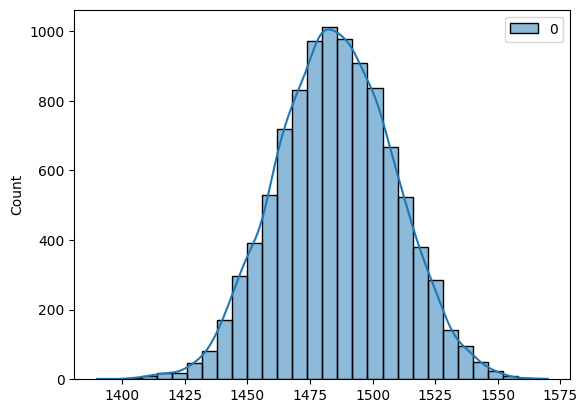

In [65]:
print('Average number of links: {:.2f}'.format(np.mean(LinkS)))
print('Standard deviation: {:.2f}'.format(np.std(LinkS)))

print('Expected number of links: {:.2f}'.format(Plink*Nnode*(Nnode-1)/2))
print('Expected standard deviation: {:.2f}'.format(np.sqrt(Plink*(1-Plink)*Nnode*(Nnode-1)/2)))

sns.histplot(data=LinkS, bins=30, kde=True)

The degree distribution for increasing size - CV decreases.
Tends to the delta function - regular graph.

In [66]:
Pow = 4.21 # max network size
Pl = 0.1
Cnt = 0

M = []
S = []
CV = []
Nnodes = []

In [67]:
for index in np.arange(2, Pow, step=0.3):
    Nnodes.append(int(10**index))
    NetC = sp.sparse.triu(sp.sparse.rand(Nnodes[Cnt], Nnodes[Cnt], density=Pl, format='csr'), k=1)
    NetC = NetC + NetC.T
    K = sum(NetC).todense()
    M.append(np.mean(K))
    S.append(np.std(K))
    CV.append(np.std(K)/np.mean(K))
    # sns.histplot(data=K, bins=30, kde=True, label='N={:d}'.format(Nnodes[Cnt]))
    print('N={:d} - Average degree: {:.2f}'.format(Nnodes[Cnt], M[Cnt]))
    print('N={:d} - Standard deviation: {:.2f}'.format(Nnodes[Cnt], S[Cnt]))
    print('N={:d} - CV: {:.2f}'.format(Nnodes[Cnt], CV[Cnt]))
    Cnt += 1

N=100 - Average degree: 4.50
N=100 - Standard deviation: 1.62
N=100 - CV: 0.36
N=199 - Average degree: 9.76
N=199 - Standard deviation: 2.39
N=199 - CV: 0.25
N=398 - Average degree: 19.72
N=398 - Standard deviation: 3.19
N=398 - CV: 0.16
N=794 - Average degree: 39.65
N=794 - Standard deviation: 4.83
N=794 - CV: 0.12
N=1584 - Average degree: 79.53
N=1584 - Standard deviation: 6.86
N=1584 - CV: 0.09
N=3162 - Average degree: 158.26
N=3162 - Standard deviation: 9.98
N=3162 - CV: 0.06
N=6309 - Average degree: 314.95
N=6309 - Standard deviation: 14.07
N=6309 - CV: 0.04
N=12589 - Average degree: 629.21
N=12589 - Standard deviation: 19.65
N=12589 - CV: 0.03


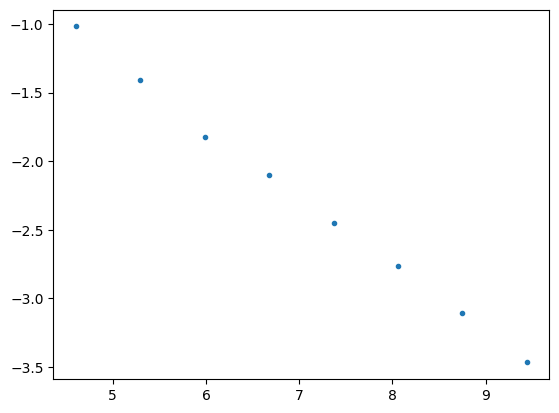

In [68]:
plt.plot(np.log(Nnodes), np.log(CV), '.')

## Giant component transition

In [69]:
Nnode = int(1e2)

rr = np.triu(np.random.rand(Nnode, Nnode), k=1)
rr = rr + rr.T

In [70]:
Pmin = 1 / (20 * Nnode)
Pmax = 6 / Nnode
xP = np.arange(Pmin, Pmax, step=0.00002)

**NOTE** that $\lambda = xP * Nnode$

In [71]:
Rc = np.zeros(len(xP))
Rm = np.zeros(len(xP))
Cnt = 0

for index in xP:
    Net = nx.from_numpy_array(rr > 1 - index)
    CompList = nx.connected_components(Net)
    Comps = [len(x) for x in CompList]
    Rc[Cnt] = max(Comps)
    Rm[Cnt] = np.mean(Comps)
    Cnt += 1

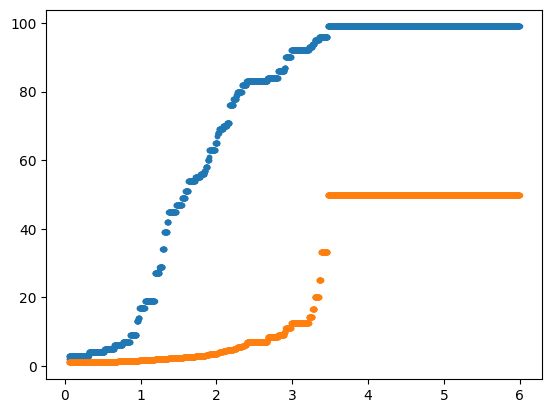

In [72]:
plt.plot(xP*Nnode, Rc, '.')
plt.plot(xP*Nnode, Rm, '.')

## Semicircle law for ER network spectrum vs RMT (Random Matrix Theory)

<Axes: >

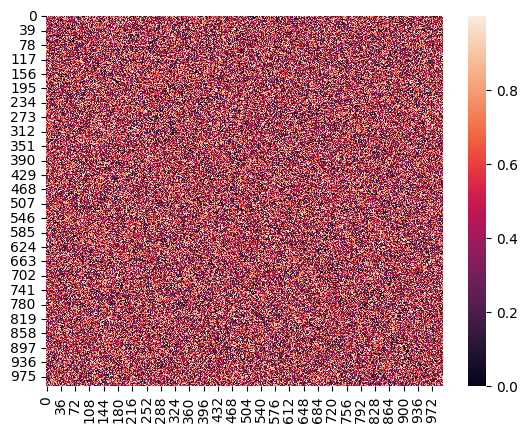

In [73]:
Nnode = int(1e3)
Plink = 0.2 # link probability (canonical)

rr = np.triu(np.random.rand(Nnode, Nnode), k=1)
rr = rr + rr.T
np.fill_diagonal(rr, 0) # remove loops

# plot matrix with values
sns.heatmap(rr)

Let's see also the histogram of coefficients

<Axes: ylabel='Count'>

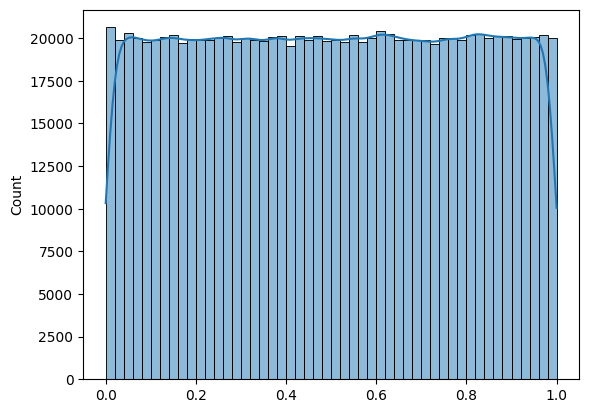

In [74]:
sns.histplot(data=rr.ravel(), bins=50, kde=True)

Now the eigenvalues and eigenvectors.

**NOTE** A symmetric ER network has a real semicircle spectrum

<Axes: ylabel='Count'>

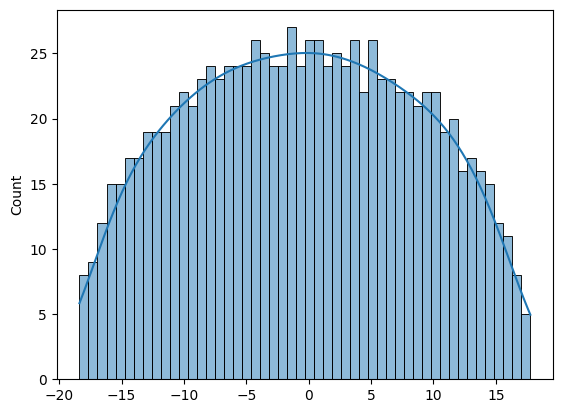

In [75]:
vv = np.linalg.eigvals(rr)
sns.histplot(data=vv[vv < vv.max()], bins=50, kde=True)

In [76]:
rr = np.triu(np.random.rand(Nnode, Nnode), k=1) > 1 - Plink
rr = rr + rr.T

In [77]:
vv, vec = np.linalg.eig(rr)

<Axes: ylabel='Count'>

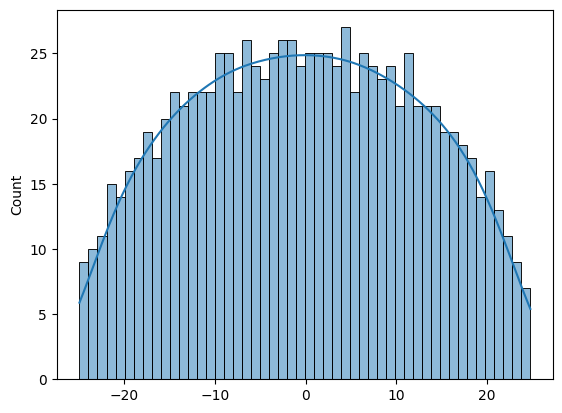

In [78]:
sns.histplot(data=vv[vv < vv.max()], bins=50, kde=True)

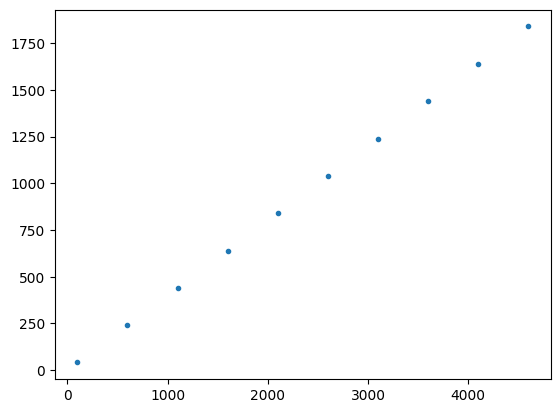

In [83]:
Cnt = 0
xx = np.arange(100, 5000, step=500)
vmax = []

for index in xx:
    rr = rand_canonical_f(index, Plink)
    vv = np.linalg.eigvals(rr)
    vmax.append(np.max(vv))
    Cnt += 1

plt.plot(xx, vmax, '.')

For a directed random matrix we'll have a complex circular spectrum

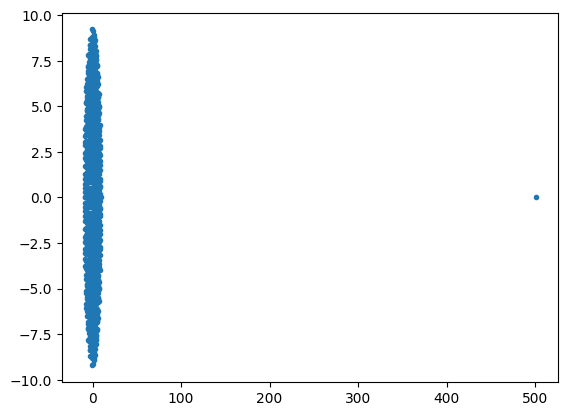

In [80]:
rr = np.random.rand(Nnode, Nnode)
vv = np.linalg.eigvals(rr)
vvr = np.real(vv)
vvi = np.imag(vv)
plt.plot(vvr, vvi, '.')

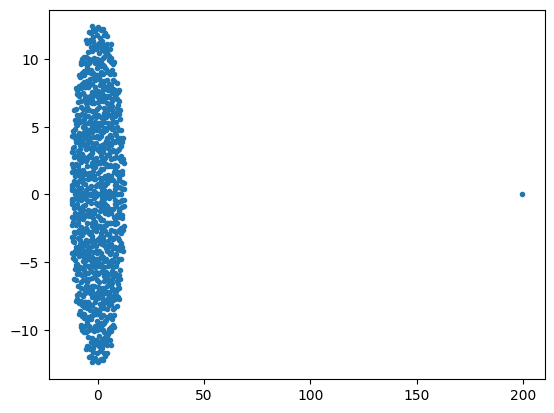

In [81]:
rr = np.random.rand(Nnode, Nnode) > 1 - Plink
np.fill_diagonal(rr, 0)
vv = np.linalg.eigvals(rr)
vvr = np.real(vv)
vvi = np.imag(vv)
plt.plot(vvr, vvi, '.')